# Dependencies

In [2]:
import os
import sys

sys.path.append(os.getcwd().split('notebooks')[0])

from src.utilities.utils import *

Device: cpu


In [3]:
import random
# import wandb
import numpy as np
from dotmap import DotMap

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader

import sys
from src.utilities.helper_functions import *

from src.tensor_completion_models.CoSTCo import *
from src.tensor_completion_models.CPD import *
# from src.tensor_completion_models.tuckER import *
from src.tensor_completion_models.ETC import *

import matplotlib.pyplot as plt
from sklearn.utils.validation import check_random_state
import tensorly as tl
from torch.nn.init import xavier_normal_

from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split, KFold

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cpu


# Load Tensor

In [4]:
original_tensor = None
for_queries = False
file = None

### Query Tensors

In [5]:
# file = "AND_AND_801"
# file = "AND_OR_801"
# file = "OR_AND_801"
# file = "OR_OR_801"

# file = "AND_AND_distinct_817"
# file = "AND_OR_distinct_817"
# file = "OR_AND_distinct_817"
# file = "OR_OR_distinct_817"

if (file is not None): 
    file = 'query_tensors/' + file
    original_tensor = torch.load(f"{meta_data_folder}{file}.pt")

### Hyperparameter Tensors

In [6]:
# file = "FCNN_biodeg_828"          # CoSTCo is barely better than naive median
# file = "FCNN_Dermatology_829"     # good one

if (file is not None and len(file.split("/")) == 1): file = "deep_learning/" + file

# file = "RF_Glass_828"
# file = "SVM_Dermatology_828"           # very trivial, but CoSTCo still slightly better than naive
# file = "RF_Dermatology_828"            # good one
# file = "ET_Dermatology_828"            # good one
# file = "DT_Dermatology_828"
# file = "KNN_car_evaluation_828"        # good one
# file = "DT_Spambase_829"               # good one
# file = "RF_Spambase_829"               # good one
# file = "ET_Spambase_829"               # good one
# file = "GB_Spambase_829"               # good one

if (file is not None and len(file.split("/")) == 1): file = "non_deep/" + file

if (file is not None): 
    original_tensor = torch.load(f"{meta_data_folder}{file}.pt")

In [7]:
if (file is not None): print(f"Tensor File: /training_tensors/{file}.")

### Looking at Tensor

In [8]:
if (file is not None):
    plt.hist([float(x) for x in original_tensor.flatten()], bins = 30)
    plt.xlim(0, 1)
    plt.xticks([original_tensor.min(), original_tensor.max()])
    plt.show()

In [9]:
if (file is not None):
    plt.boxplot([float(x) for x in original_tensor.flatten()])
    plt.ylim(0, 1)
    plt.show()

In [10]:
if (file is not None):
    print(f"Tensor shape: {original_tensor.shape}")
    total_cells = 1
    for s in original_tensor.shape: total_cells*=s

    print(f"{total_cells} total cells in tensor.")

# Train & Evaluate

### Setup

In [34]:
tensors = [
           torch.load(f"{meta_data_folder}non_deep/RF_Spambase_829.pt"),
           torch.load(f"{meta_data_folder}deep_learning/FCNN_Dermatology_829.pt"),
           
           torch.load(f"{meta_data_folder}query_tensors/AND_OR_801.pt"),
           torch.load(f"{meta_data_folder}query_tensors/AND_AND_distinct_817.pt")
           ]



tensor_labels = [
    ['Non-Deep Learning', 'RF_Spambase_829'],
    ['Deep Learning', 'FCNN_Dermatology_829'],
    
    ['Query Cardinality', 'AND_OR_801'],
    ['Distinct Cardinality', 'AND_AND_distinct_817']
]


query_tensors = [2, 3]

for q in query_tensors:
    tensors[q] = (tensors[q] - tensors[q].min()) / (tensors[q].max() - tensors[q].min())

In [35]:
num_epochs = 10000
batch_size = 512
lr = 5e-3
wd = 1e-4
val_size = 0.2

num_iterations = 5

ranks = [1, 2, 3, 5]
# ranks = [2]
# ranks = [None]

lambda_values = [0.0, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# lambda_values = [0, 2, 5, 10]

portion = 0.02

### Function

In [13]:
def get_MAEs(full_t):

        MAEs = list()
        
        # original_tensor_sparse = get_sparse_tensor(t = full_t.clone(), portion = 1.0)

        for lambda_value in lambda_values:

                it_MAEs = list()
                
                lambda_str = str()
                if (lambda_value % 1 == 0): lambda_str = str(int(lambda_value))
                else: lambda_str = str(lambda_value)
                
                print(f"Lambda {lambda_str} iteration:", end = " ")
                for it in range(1, num_iterations+1):
                        
                        sparse_tensor = get_sparse_tensor(t = full_t.clone(),
                                                        portion = portion,
                                                        verbose = False)
                        
                        rank_MAEs = list()
                        for rank in ranks:
                                
                                model_MAEs = list()
        
                                        
        # _________________________________________________________________________________________________________________________________________________________________

                                
                                # Naive Tensor Completion Methods
                                
                                model_MAEs += [get_naive_unique_MAE(sparse_tensor = sparse_tensor, 
                                                                original_tensor = full_t, 
                                                                random_method = 'sampling')]
        
        # _________________________________________________________________________________________________________________________________________________________________

                                
                                model = train_tensor_completion(model_type = 'cpd',
                                                                sparse_tensor = sparse_tensor,
                                                                rank = rank,
                                                                num_epochs = num_epochs,
                                                                batch_size = batch_size,
                                                                cpd_smooth_lambda=lambda_value,
                                                                lr = 5e-3,
                                                                wd = wd,
                                                                early_stopping = True,
                                                                flags = 15,
                                                                val_size = 0.2,
                                                                convert_to_cpd = False,
                                                                for_queries = for_queries,
                                                                device = device)
                                
                                model_MAEs += [get_unique_MAE(model = model,
                                                        full_t = full_t.clone(),
                                                        sparse_t = sparse_tensor.clone(),
                                                        return_errors = False,
                                                        return_indices = False,
                                                        device = device)]
                                
                                
                                del model     
                
        # _________________________________________________________________________________________________________________________________________________________________

                                
                                model = train_tensor_completion(model_type = 'cpd.smooth',
                                                                sparse_tensor = sparse_tensor,
                                                                rank = rank,
                                                                num_epochs = num_epochs,
                                                                batch_size = batch_size,
                                                                cpd_smooth_lambda=lambda_value,
                                                                lr = 5e-3,
                                                                wd = wd,
                                                                early_stopping = True,
                                                                flags = 15,
                                                                val_size = 0.2,
                                                                convert_to_cpd = False,
                                                                for_queries = for_queries,
                                                                device = device)
                                
                                model_MAEs += [get_unique_MAE(model = model,
                                                        full_t = full_t.clone(),
                                                        sparse_t = sparse_tensor.clone(),
                                                        return_errors = False,
                                                        return_indices = False,
                                                        device = device)]
                                
                                
                                del model
                                
        
        # _________________________________________________________________________________________________________________________________________________________________
                                
                                rank_MAEs += [model_MAEs]
                                
                        it_MAEs +=[rank_MAEs]

                        if (it == num_iterations): print(it)
                        else: print(it, end = ", ")

                MAEs += [it_MAEs]

        MAEs = np.array(MAEs)

        print("\nAll done!")
        
        return MAEs

### Display

In [14]:
all_MAEs = list()
for t in range(len(tensors)):
    
    print(f"\n\nTensor {t+1} of {len(tensors)}.")
    this_t = tensors[t]
    all_MAEs += [get_MAEs(this_t)]
    
all_MAEs = np.array(all_MAEs)
print("\n\nAll Tensors Done!")



Tensor 1 of 4.
Lambda 0 iteration: 1, 2, 3, 4, 5
Lambda 0.5 iteration: 1, 2, 3, 4, 5
Lambda 1 iteration: 1, 2, 3, 4, 5
Lambda 2 iteration: 1, 2, 3, 4, 5
Lambda 3 iteration: 1, 2, 3, 4, 5
Lambda 4 iteration: 1, 2, 3, 4, 5
Lambda 5 iteration: 1, 2, 3, 4, 5
Lambda 6 iteration: 1, 2, 3, 4, 5
Lambda 7 iteration: 1, 2, 3, 4, 5
Lambda 8 iteration: 1, 2, 3, 4, 5
Lambda 9 iteration: 1, 2, 3, 4, 5
Lambda 10 iteration: 1, 2, 3, 4, 5

All done!


Tensor 2 of 4.
Lambda 0 iteration: 1, 2, 3, 4, 5
Lambda 0.5 iteration: 1, 2, 3, 4, 5
Lambda 1 iteration: 1, 2, 3, 4, 5
Lambda 2 iteration: 1, 2, 3, 4, 5
Lambda 3 iteration: 1, 2, 3, 4, 5
Lambda 4 iteration: 1, 2, 3, 4, 5
Lambda 5 iteration: 1, 2, 3, 4, 5
Lambda 6 iteration: 1, 2, 3, 4, 5
Lambda 7 iteration: 1, 2, 3, 4, 5
Lambda 8 iteration: 1, 2, 3, 4, 5
Lambda 9 iteration: 1, 2, 3, 4, 5
Lambda 10 iteration: 1, 2, 3, 4, 5

All done!


Tensor 3 of 4.
Lambda 0 iteration: 1, 2, 3, 4, 5
Lambda 0.5 iteration: 1, 2, 3, 4, 5
Lambda 1 iteration: 1, 2, 3, 4, 5
L

### Swap Out a Tensor for the Graph

In [36]:
swap_out = 2

if (swap_out is not None):
    
    if (type(swap_out) != type(list())): swap_out = [swap_out]
    
    for s in swap_out:
        this_t = tensors[s]
        all_MAEs[s] = get_MAEs(this_t)

Lambda 0 iteration: 1, 2, 3, 4, 5
Lambda 0.5 iteration: 1, 2, 3, 4, 5
Lambda 1 iteration: 1, 2, 3, 4, 5
Lambda 2 iteration: 1, 2, 3, 4, 5
Lambda 3 iteration: 1, 2, 3, 4, 5
Lambda 4 iteration: 1, 2, 3, 4, 5
Lambda 5 iteration: 1, 2, 3, 4, 5
Lambda 6 iteration: 1, 2, 3, 4, 5
Lambda 7 iteration: 1, 2, 3, 4, 5
Lambda 8 iteration: 1, 2, 3, 4, 5
Lambda 9 iteration: 1, 2, 3, 4, 5
Lambda 10 iteration: 1, 2, 3, 4, 5

All done!


# Plot Results

In [37]:
labels = [
          'Naive',
          'CPD',
          'CPD-S'
          ]

colors = ['black', 'blue', 'green']

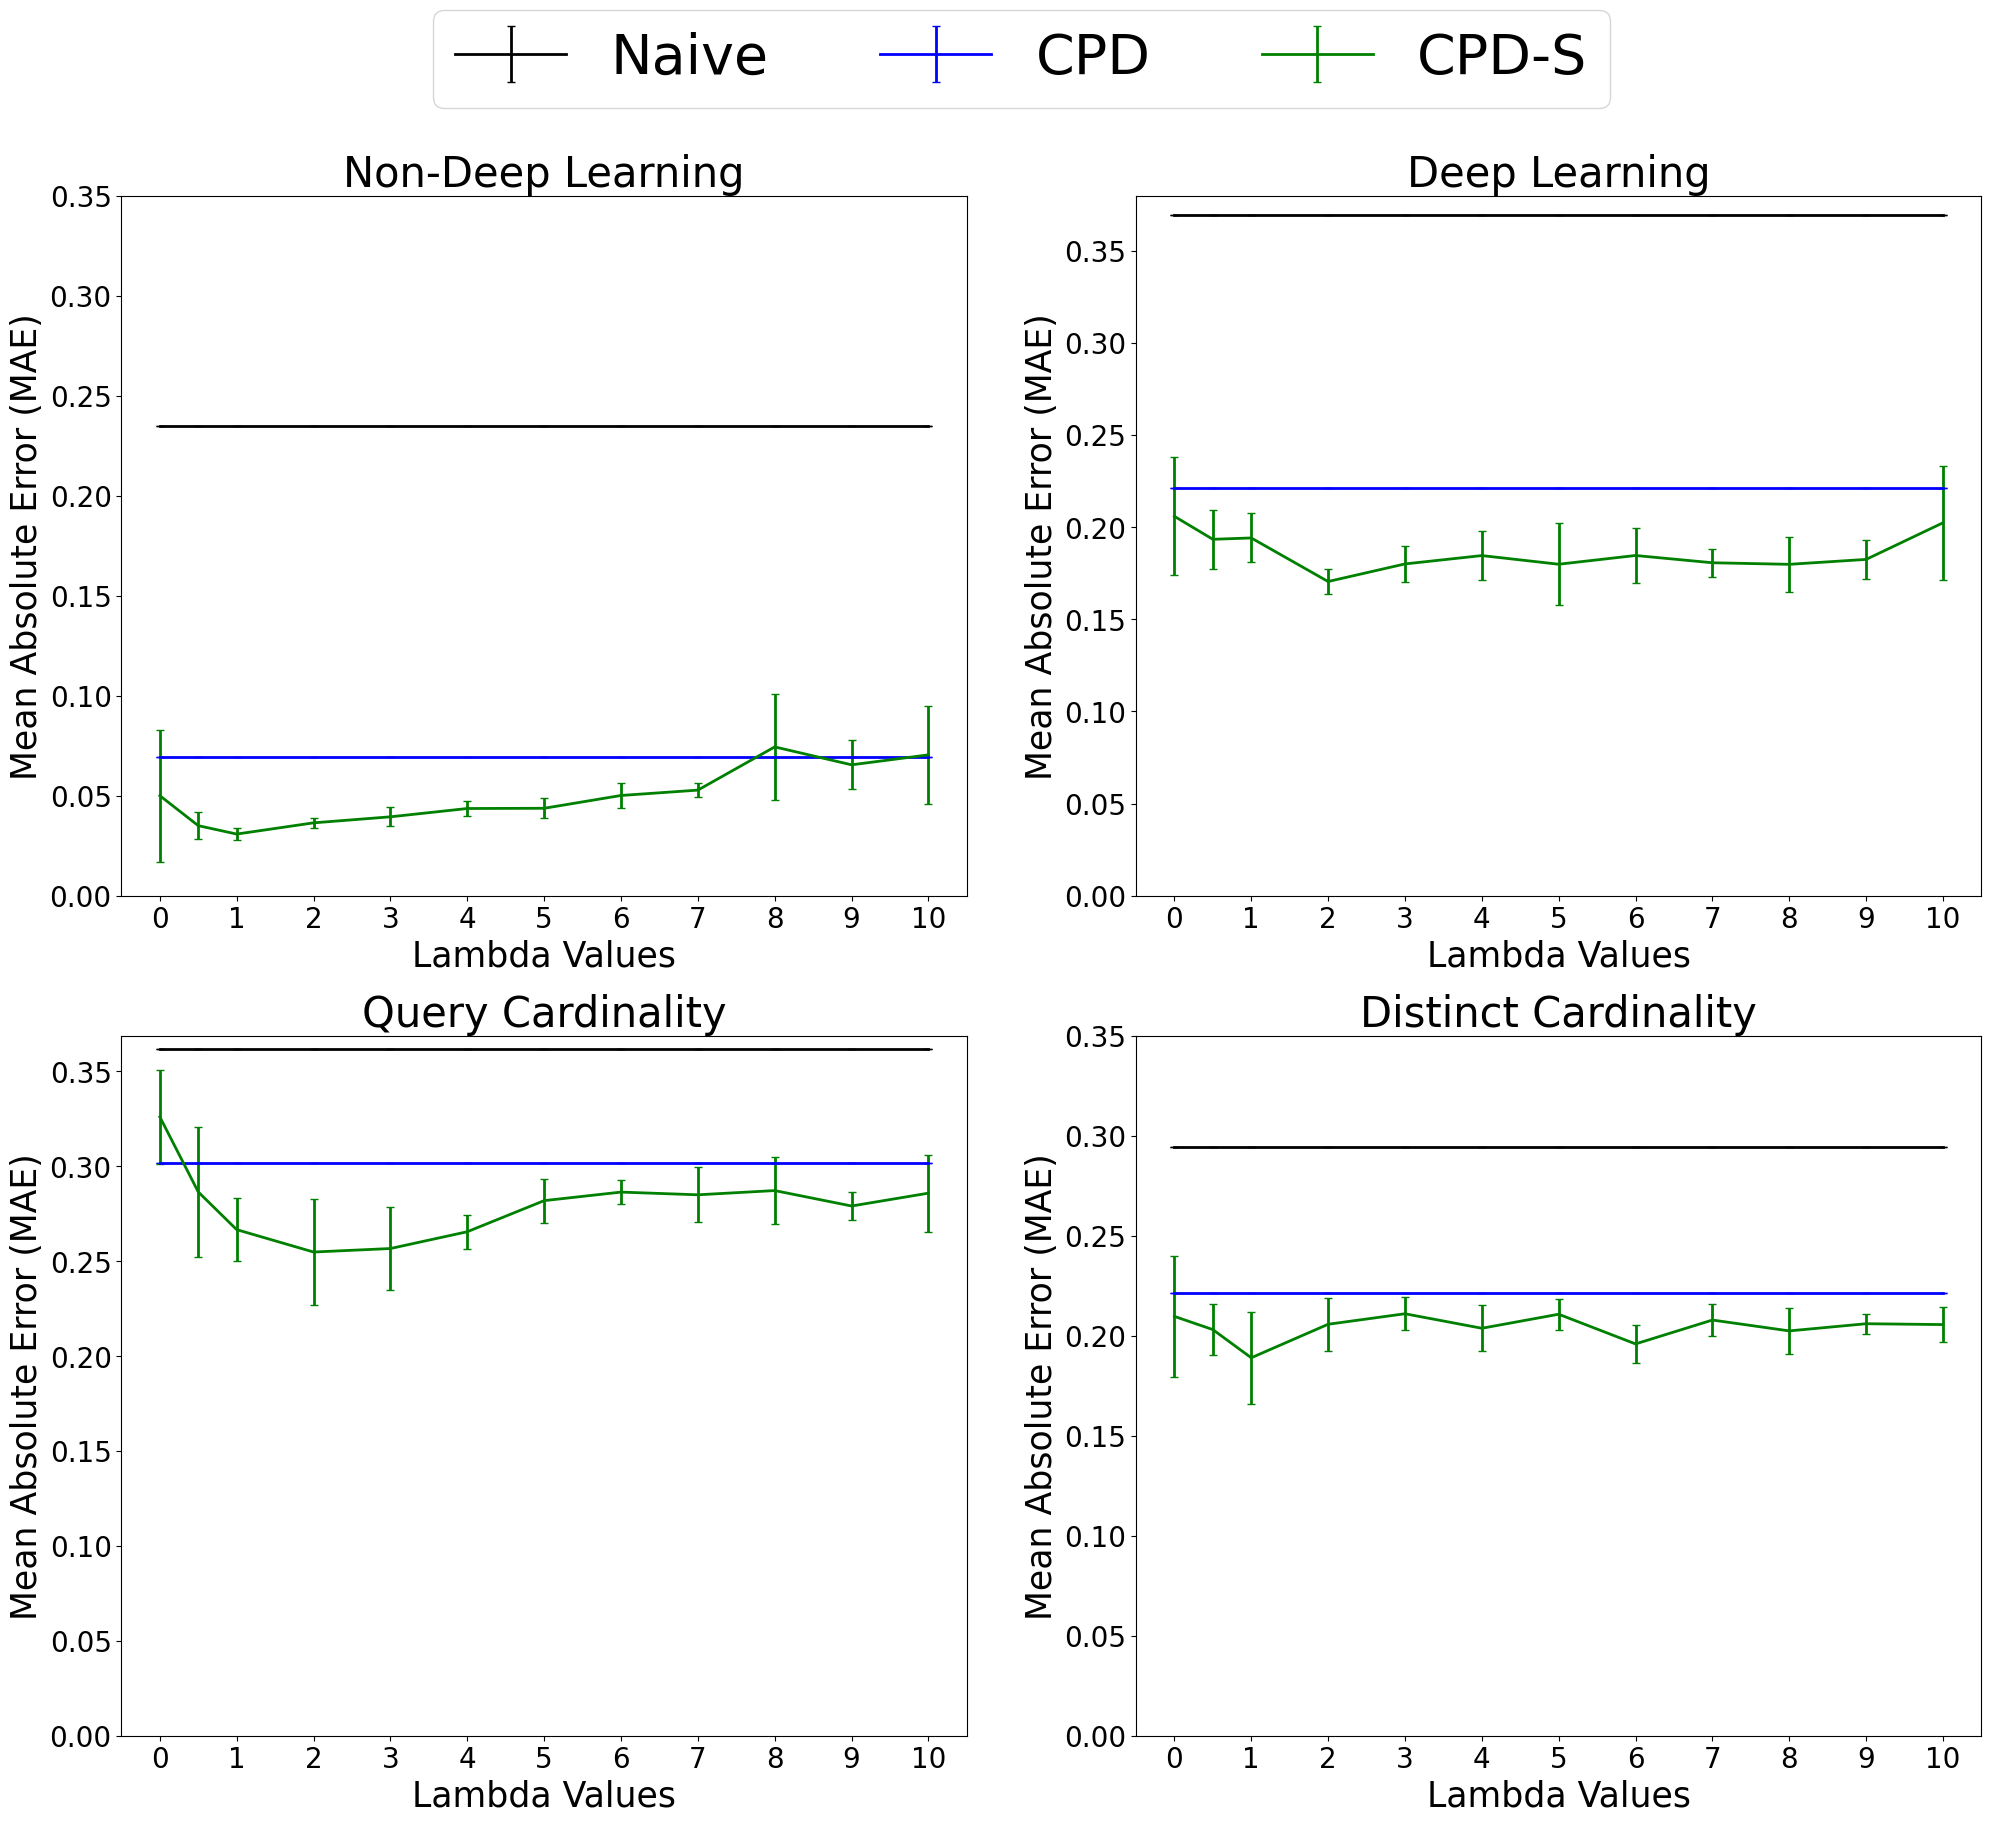

In [38]:
fig, axs = plt.subplots(2, 2, figsize=(24, 20))
lines = list()
for r in range(2):
    
    for c in range(2):

        MAEs = all_MAEs[(r*2)+c]
        
        sub_plot = axs[r, c]

        x = lambda_values

        for i in range(MAEs.shape[-1]):
            # if (labels[i] == 'Naive'): continue
            current_model = MAEs[:, :, :, i]
                        
            current_model = current_model.min(axis = 2)
            
            if (labels[i] == 'CPD-S'): 
                
                line = sub_plot.errorbar(x, 
                                        current_model.mean(axis = 1), 
                                        yerr=current_model.std(axis = 1), 
                                        label=labels[i], 
                                        color = colors[i],
                                        capsize=3, 
                                        linewidth=2)
                
            else:
                mean_value = current_model.mean()
                line = sub_plot.errorbar(x, 
                                        [mean_value for c in range(current_model.mean(axis = 1).shape[0])], 
                                        yerr=[0 for c in range(current_model.mean(axis = 1).shape[0])], 
                                        label=labels[i], 
                                        color = colors[i],
                                        capsize=3, 
                                        linewidth=2)
            
            lines+= [line]
            

        sub_plot.set_xlabel('Lambda Values', fontsize=25)
        sub_plot.set_ylabel('Mean Absolute Error (MAE)', fontsize=25)


        sub_plot.set_title(f"{tensor_labels[(r*2)+c][0]}", fontsize = 30)
        sub_plot.set_xticks([s for s in range(int(x[0]), int(x[-1]+1))])
        
        sub_plot.tick_params(axis='x', labelsize=20)
        sub_plot.tick_params(axis='y', labelsize=20)

        sub_plot.set_yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35])
        
        
        if (file is None): file_s = ""
        else: file_s = " (" + file + ".pt)"

        sub_plot.set_ylim(bottom = 0)
        
fig.legend(lines[:len(colors)], labels, loc = 'lower center', bbox_to_anchor=(0.5, 0.91), 
           ncol=len(colors), fontsize=40);